In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


#  Modelado y evaluación
# -----------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
import xgboost as xgb

In [2]:
df = pd.read_pickle("../data/bikes_registrados_estand_encod_completo.pkl")
df.head()

,estacion,año,mes,festivo,dia,meteo,temperatura,humedad,velo_viento,usu_registrados,laborable_laborable,laborable_no laborable
0,0,0,0,0,0,1,-0.486274,0.858854,-0.208909,654,0,1
1,0,0,0,1,0,1,-0.425690,0.331548,0.687550,670,1,0
2,0,0,0,1,1,2,-0.949970,-0.912000,0.685210,1229,1,0
3,0,0,0,1,1,2,-0.938563,-0.176088,-0.210435,1454,1,0
4,0,0,0,1,1,2,-0.853992,-0.913519,0.060294,1518,1,0


In [3]:
X = df.drop("usu_registrados", axis = 1)
y = df["usu_registrados"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


In [5]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

/home/arillien/anaconda3/envs/Proyecto3/lib/python3.10/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/home/arillien/anaconda3/envs/Proyecto3/lib/python3.10/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/home/arillien/anaconda3/envs/Proyecto3/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/arillien/anaconda3/envs/Proyecto3/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inste

In [6]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}

In [7]:
n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [8]:
preds = model.predict(dtest_reg)

In [9]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 600.220


In [10]:
y_pred_test_rf = model.predict(dtest_reg)
y_pred_train_rf = model.predict(dtrain_reg)

In [11]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [12]:
xgb_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "XGBoost")
xgb_results

,MAE,MSE,RMSE,R2,set,modelo
0,440.171323,360263.495506,600.219539,0.855371,test,XGBoost
1,17.507771,661.714950,25.723821,0.999725,train,XGBoost


<h2> RANDOM FOREST </h2>

In [13]:
m = len(X.columns)

params = dict(
    objective="reg:squarederror",
    learning_rate=1,
    num_parallel_tree=500,
    subsample=0.63,
    colsample_bynode=int(np.sqrt(m))/m,
    reg_lambda=0,
    max_depth=20,
    min_child_weight=2
)

In [14]:
rf_xgb = xgb.train(  # Wall time 34 s
    params, 
    dtrain_reg, 
    num_boost_round=1
)

In [15]:
y_pred_test_xgbrf = rf_xgb.predict(dtest_reg)
y_pred_train_xgbrf = rf_xgb.predict(dtrain_reg)

In [16]:
xgb_rf_results = metricas(y_test, y_train, y_pred_test_xgbrf, y_pred_train_xgbrf, "XGBoost RF")
xgb_rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,463.982216,371196.977442,609.259368,0.850981,test,XGBoost RF
1,328.725996,193909.555501,440.351627,0.919356,train,XGBoost RF


In [17]:
from xgboost import plot_importance

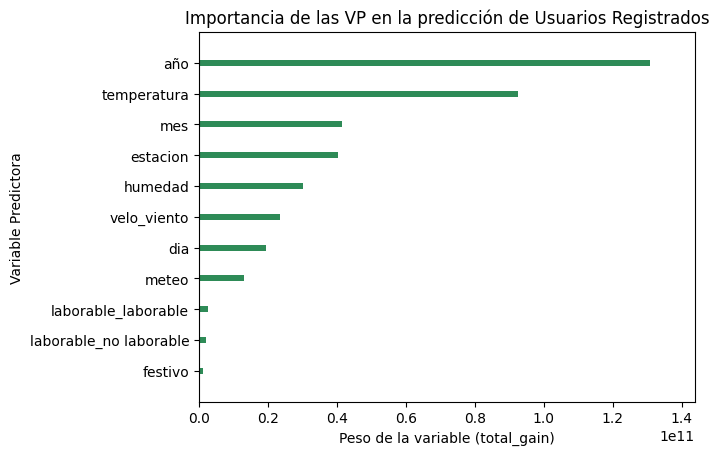

In [19]:
plot_importance(rf_xgb, importance_type= "total_gain", grid= False, show_values= False, color = 'seagreen',
                title= "Importancia de las VP en la predicción de Usuarios Registrados", xlabel= "Peso de la variable (total_gain)", ylabel= "Variable Predictora",
                );